# Step Size Adaptation with SGHMC

The step size adaptation algorithm for our implementtation of SGHMC is called: dual-averaging step size adaptation. See the following blog post for implementation details: https://colindcarroll.com/2019/04/21/step-size-adaptation-in-hamiltonian-monte-carlo/

This feature is currently very unstable do **not** use without caution.

**TODO** make this compatible with b-hat estimation

In [1]:
from matplotlib import pyplot as plt
import torch
import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
import numpy as np

from sghmc import SGHMC

In [2]:
# Coin flip example - we flip two coins indepdenently x1 corresponds to the observed outcomes of coin1 
# and x2 corresponds to the observed outcomes of coin2 
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

# create some data with 2 observed heads and 8 observed tails
x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

    
def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

In [3]:
BATCH_SIZE = 5
# SGHMC without step size adaptation - hand tuned step size
sghmc_wo_sta = SGHMC(model, 
                     subsample_positions=[0, 1],
                     batch_size=BATCH_SIZE, 
                     step_size=0.1, 
                     num_steps=5, 
                     with_friction=True, 
                     friction_term=None, 
                     friction_constant=1.0,
                     obs_info_noise=True,
                     do_mh_correction=False,
                     do_step_size_adaptation=False,
                     target_accept=0.75)

sghmc_mcmc_wo_sta = MCMC(sghmc_wo_sta, num_samples=1000)
sghmc_mcmc_wo_sta.run(x1, x2)
sghmc_samples_wo_sta = sghmc_mcmc_wo_sta.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:40, 49.87it/s, step size=1.00e-01]


In [4]:
BATCH_SIZE = 5
# SGHMC with automatic step size adaptation 
sghmc_with_sta = SGHMC(model,
                       subsample_positions=[0, 1],
                       batch_size=BATCH_SIZE, 
                       step_size=0.1, 
                       num_steps=5, 
                       with_friction=True, 
                       friction_term=None, 
                       friction_constant=1.0,
                       obs_info_noise=True,
                       do_mh_correction=False,
                       do_step_size_adaptation=True,
                       target_accept=0.75)

sghmc_mcmc_with_sta = MCMC(sghmc_with_sta, num_samples=1000)
sghmc_mcmc_with_sta.run(x1, x2)
sghmc_samples_with_sta = sghmc_mcmc_with_sta.get_samples()

Sample: 100%|████████████████████████████████████████████████████████| 2000/2000 [00:53, 37.54it/s, step size=1.27e-01]


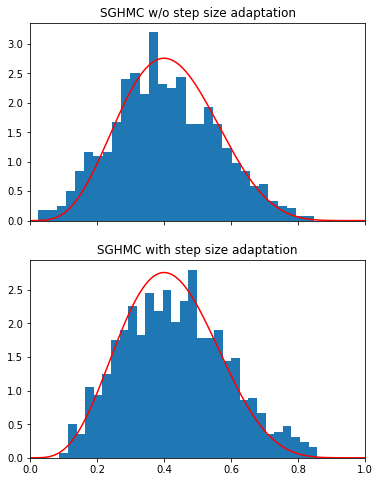

In [5]:
from torch.distributions import Beta

def analytic_posterior(x):
    fn = Beta(5., 7.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
with torch.no_grad():
    axs[0].hist(sghmc_samples_wo_sta["coin1"].numpy(), density=True, bins=30)
    axs[0].set(title="SGHMC w/o step size adaptation")
    axs[0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1].hist(sghmc_samples_with_sta["coin1"].numpy(), density=True, bins=30)
    axs[1].set(title="SGHMC with step size adaptation")
    axs[1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))
plt.show()
#posterior samples should look like a beta(5, 7) dist

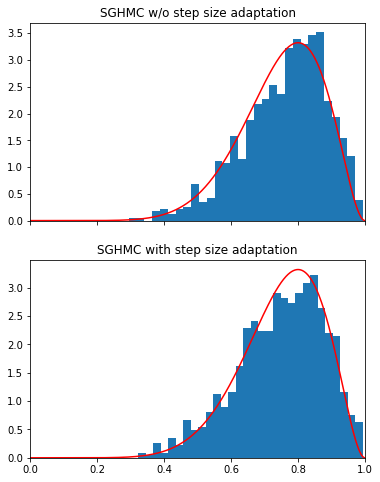

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

def analytic_posterior(x):
    fn = Beta(9., 3.)
    return np.exp(fn.log_prob(x))
    
x = torch.tensor(np.linspace(0, 1, num=1000))

with torch.no_grad():
    axs[0].hist(sghmc_samples_wo_sta["coin2"].numpy(), density=True, bins=30)
    axs[0].set(title="SGHMC w/o step size adaptation")
    axs[0].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    axs[1].hist(sghmc_samples_with_sta["coin2"].numpy(), density=True, bins=30)
    axs[1].set(title="SGHMC with step size adaptation")
    axs[1].plot(x, analytic_posterior(x), "r", label="analytic posterior")
    
plt.xlim((0.0, 1.0))
plt.show()
#posterior samples should look like a beta(9, 3) dist